In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [8]:
# Generate unitcell from ase
from ase import io
s = io.read('si.cif')
s = pc.bath.BathCell.from_ase(s)
# Add types of isotopes
s.add_isotopes(('29Si', 0.047))
# set z direction of the defect
s.zdir = [1, 1, 1]
# Generate supercell
atoms = s.gen_supercell(200, remove=[('Si', [0., 0., 0.])], seed=seed)

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 80  # in A
# Cluster cutoff radius
r_dipole = 10  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 1]; beta = [1, 0]
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 1000])  # in G
# Number of pulses in CPMG seq (0 = FID, 1 = HE etc)
pulses = 1

In [84]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter
start = 2e2
stop = 2e5
num = 10

D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz

# D_list = [10] # Note for later, very low values of D give remarkably high coherence??

# D_list = [19390]
print("D_list: ", D_list)
#############################################
# ZFS E parameter
E_start = 1
E_stop = 19390
E_num = 5
E_list = np.logspace(np.log10(E_start), np.log10(E_stop), num=E_num) 

##########################################################################################
### Other parameters
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
            ('13C',  1 / 2,  6.72828),
            ('29Si', 1 / 2, -5.3188),]

# Time points
time_space = np.linspace(0, 1, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1

##########################################################################################
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 0])  # in G
##########################################################################################


coherence_list = []
coherence_dict = {}

for D in D_list:
    for E in E_list:
        # Define the central spin
        nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

        atoms.add_type(*spin_types)
        print(nv)

        # Setting the Simulator object
        ### Setting the runner engine
        calc = pc.Simulator(spin=nv, bath=atoms, D=D, E=E,
                            r_bath=r_bath, r_dipole=r_dipole, order=order)
        print(calc)
        # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
        nspin = calc.bath
        # Set model quadrupole tensor at N atom
        quad = np.asarray([[-2.5, 0, 0],
                           [0, -2.5, 0],
                           [0, 0,  5.0]]) * 1e3 * 2 * np.pi

        nspin['Q'][nspin['N'] == '14N'] = quad
        # print(calc)

        # Hahn-echo pulse sequence
        pulse_sequence = [pc.Pulse('x',np.pi)]
        # pulse_sequence += [pc.Pulse('z',np.pi)]
        # pulse_sequence += [pc.Pulse('y',np.pi)]


        # Calculate coherence function
        l_generatilze = calc.compute(time_space, magnetic_field=b,
                                    pulses=pulse_sequence,
                                    method='gcce', quantity='coherence')
        
        # At the end of your inner loop:
        key = (D, E)
        coherence_dict[key] = l_generatilze

D_list:  [   200.         430.88694    928.31777   2000.        4308.86938
   9283.17767  20000.       43088.6938   92831.77667 200000.     ]
CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-65.66667   0.        0.     ]
  [  0.      -67.66667   0.     ]
  [  0.        0.      133.33333]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])
Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.

CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-54.86633   0.        0.     ]
  [  0.      -78.467     0.     ]
  [  0.        0.      133.33333]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])
Simulator for center array of size 1.
m

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


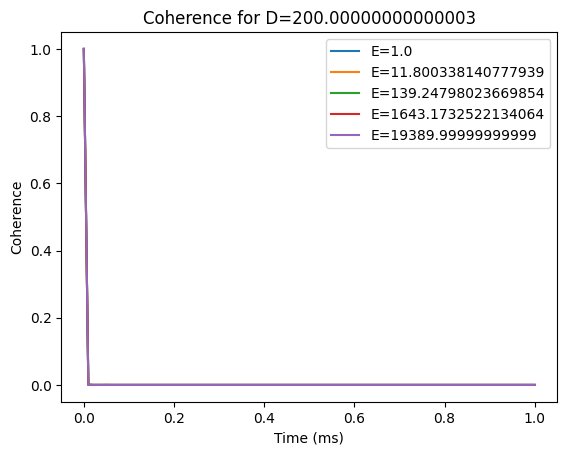

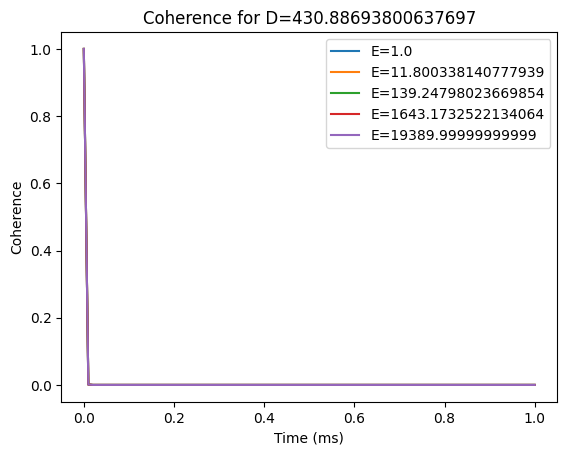

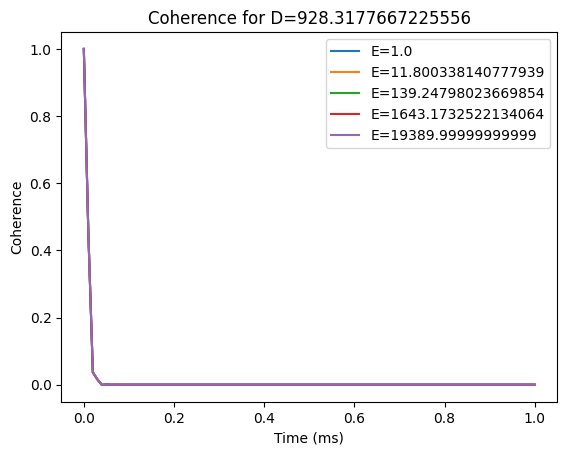

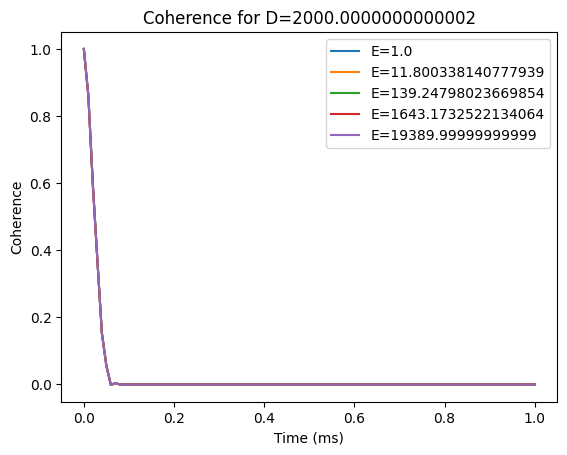

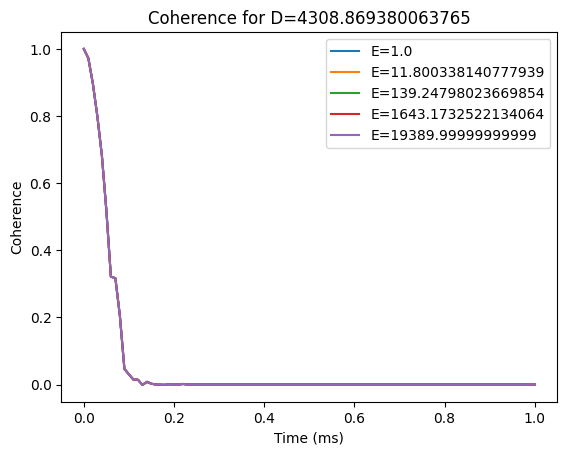

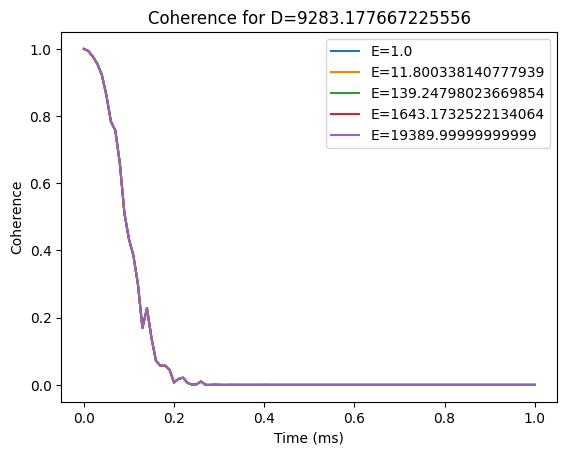

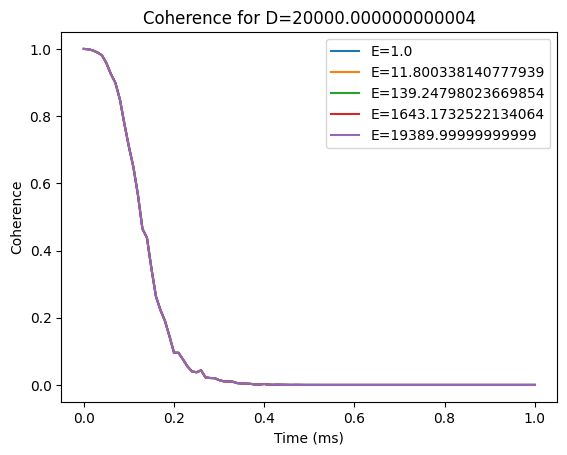

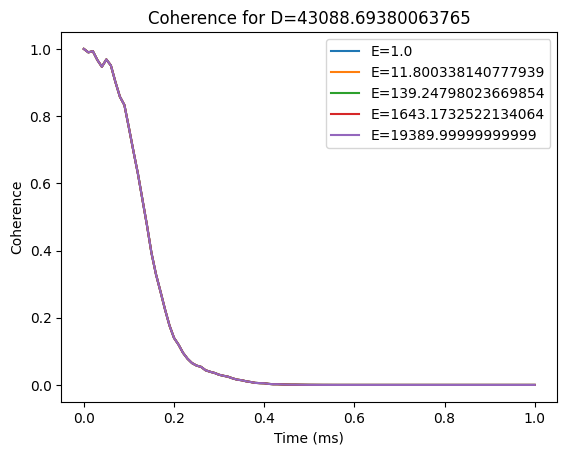

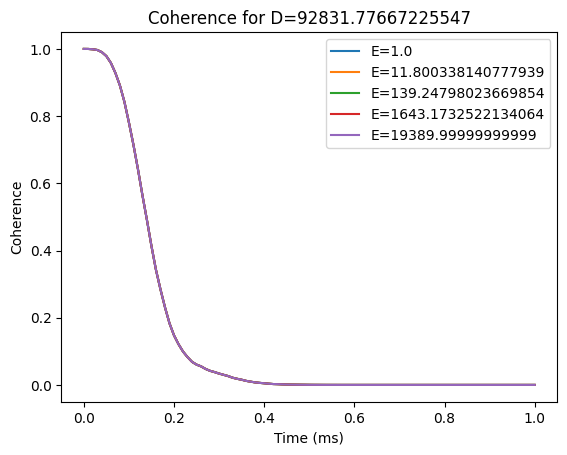

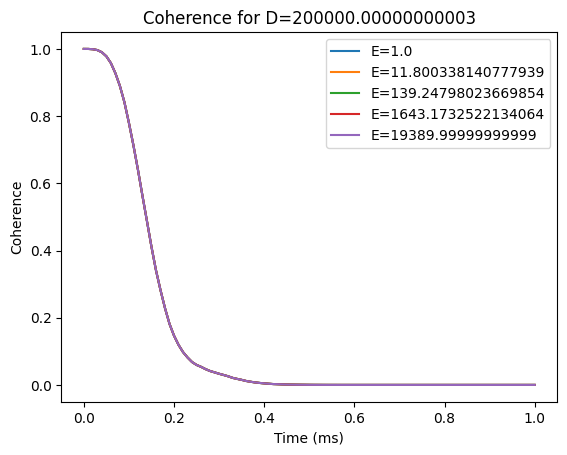

In [85]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Iterate over each unique D value
for D in unique_D_values:
    # plt.figure(figsize=(10,7))
    for E in unique_E_values:
        coherence_for_DE = coherence_dict[(D, E)]
        plt.plot(time_space, coherence_for_DE, label=f'E={E}')
    
    plt.title(f'Coherence for D={D}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Coherence')
    plt.legend()
    plt.show()

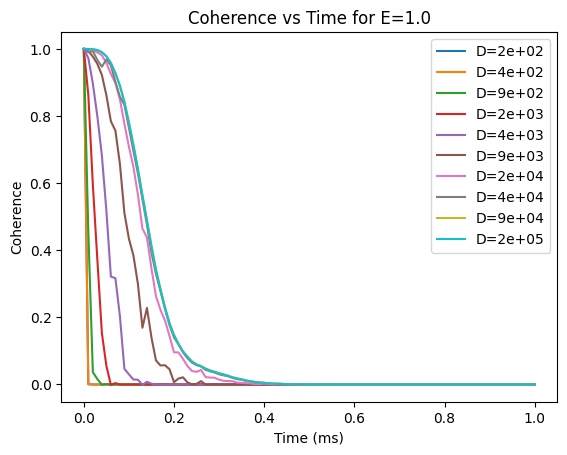

In [86]:
# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_for_smallest_E = [coherence_dict[(D, smallest_E)] for D in unique_D_values]

plt.figure()
for i, D_val in enumerate(unique_D_values):
    plt.plot(time_space, coherence_for_smallest_E[i], label=f'D={D_val:.0e}')
    
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.legend()
plt.title(f'Coherence vs Time for E={smallest_E}')
# plt.ylim(0,10)
plt.show()


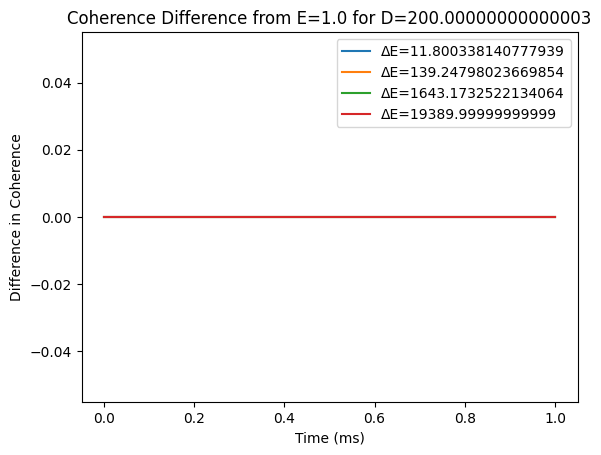

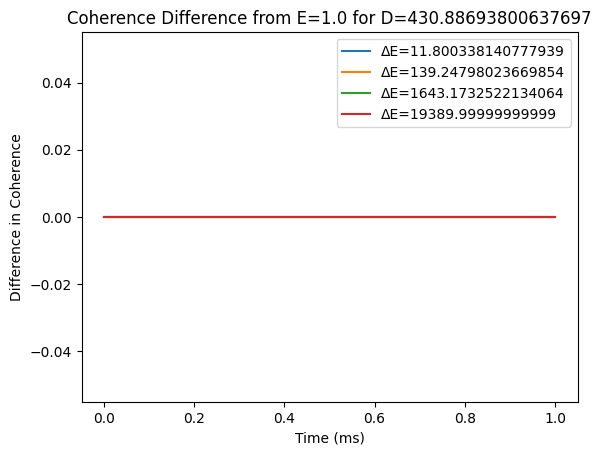

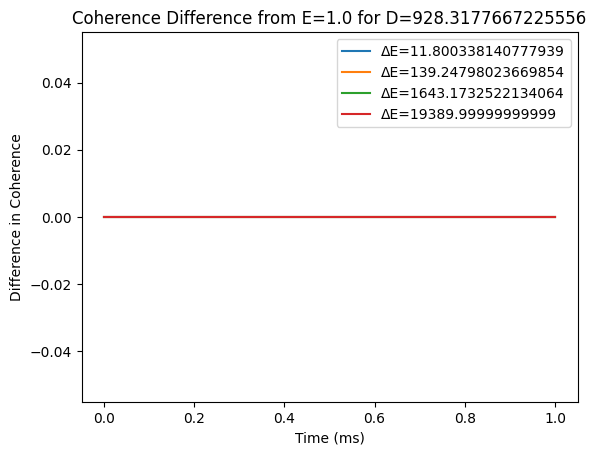

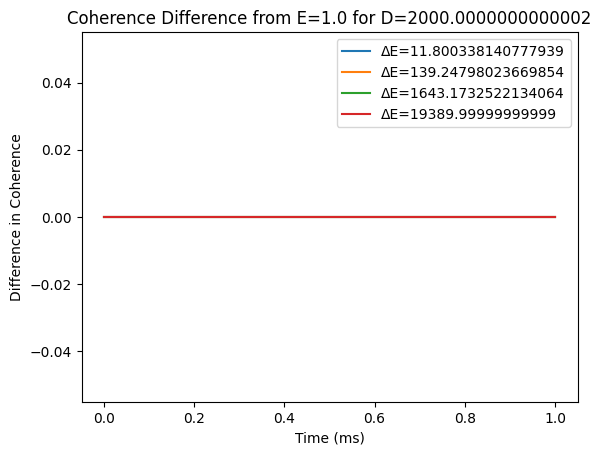

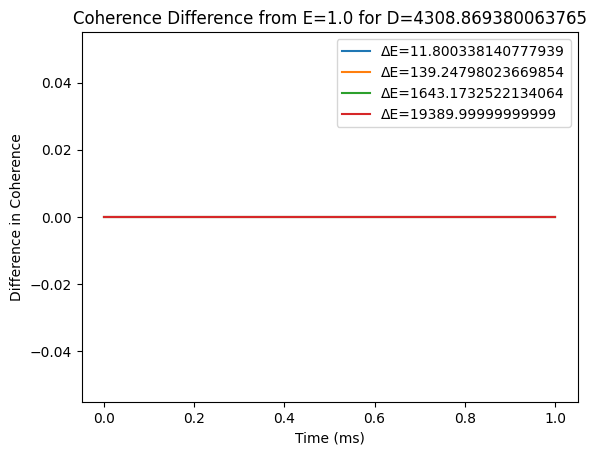

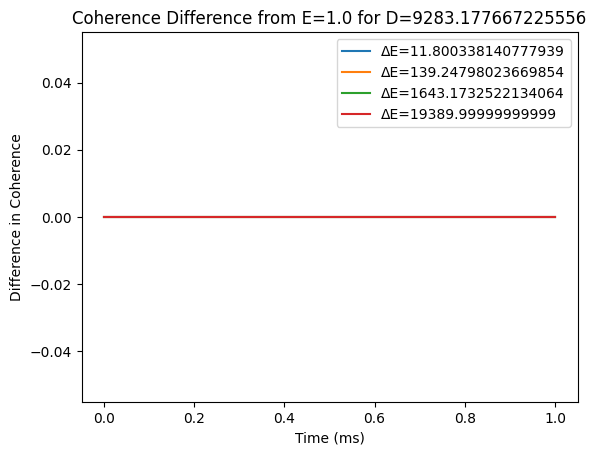

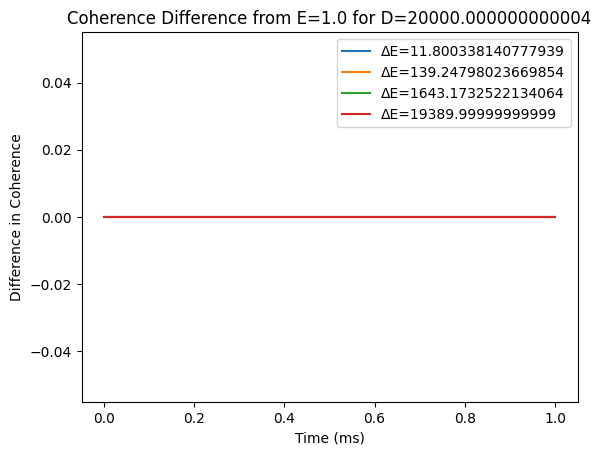

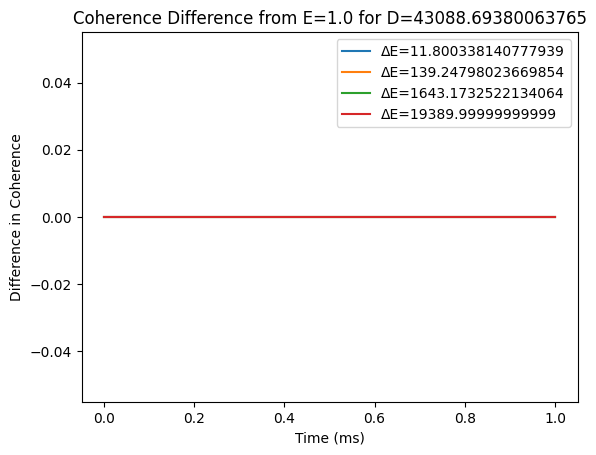

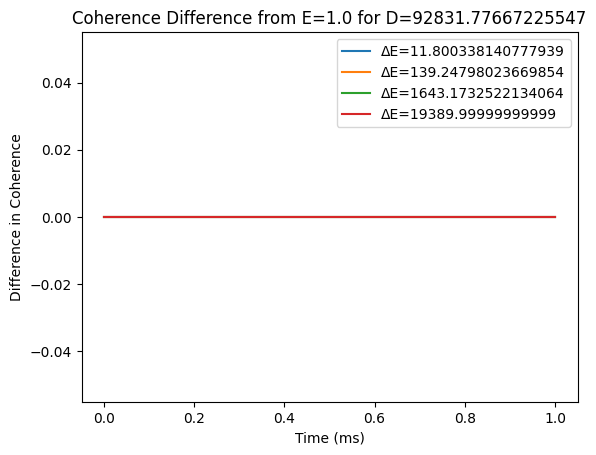

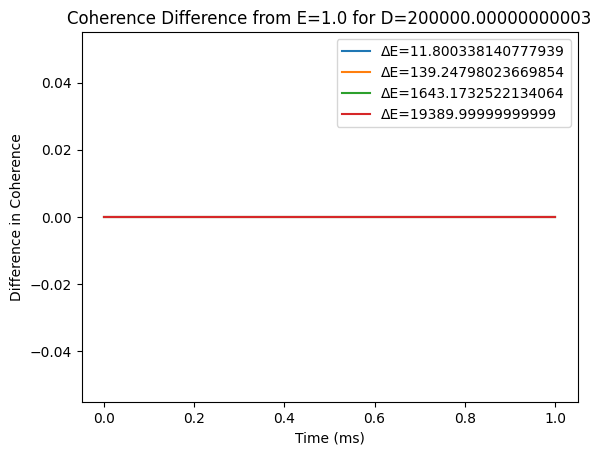

In [87]:
# Visualize difference in coherence for different E values

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))


# Reference coherence for smallest E
ref_E_value = min(E_list)

# Iterate over each unique D value
for D in unique_D_values:
    # The reference coherence changes for each D. Update the ref_coherence for each D.
    ref_coherence = coherence_dict[(D, ref_E_value)]

    # plt.figure(figsize=(10,7))
    for E in unique_E_values:
        if E == ref_E_value:  # Don't plot the difference for the reference E
            continue
        coherence_for_DE = coherence_dict[(D, E)]
        
        # Plot the difference
        difference = coherence_for_DE - ref_coherence
        plt.plot(time_space, difference, label=f'ΔE={E}')
    
    plt.title(f'Coherence Difference from E={ref_E_value} for D={D}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference in Coherence')
    plt.legend()
    plt.show()


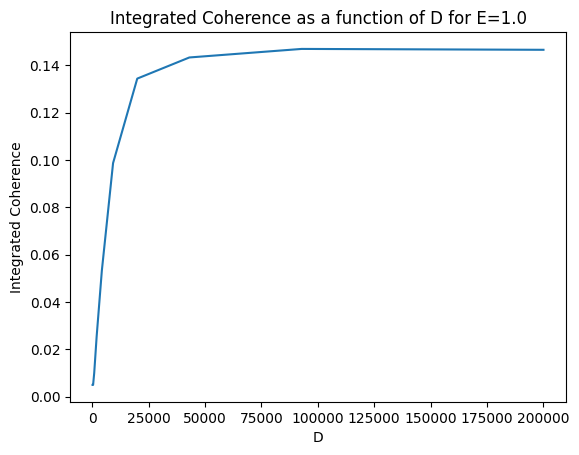

In [88]:
def integrate(x_list, y_list):
    """
    Integrate a list of y values with respect to a list of x values.
    """
    return np.trapz(y_list, x_list)

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest E
ref_E_value = min(E_list)

# Integrate each coherence curve for each D at the reference E value
integrated_coherence = [integrate(time_space, coherence_dict[(D, ref_E_value)]) for D in unique_D_values]

# Plot the integrated coherence as a function of D
plt.figure()
plt.plot(unique_D_values, integrated_coherence)
plt.xlabel('D')
plt.ylabel('Integrated Coherence')
plt.title(f'Integrated Coherence as a function of D for E={ref_E_value}')
plt.show()


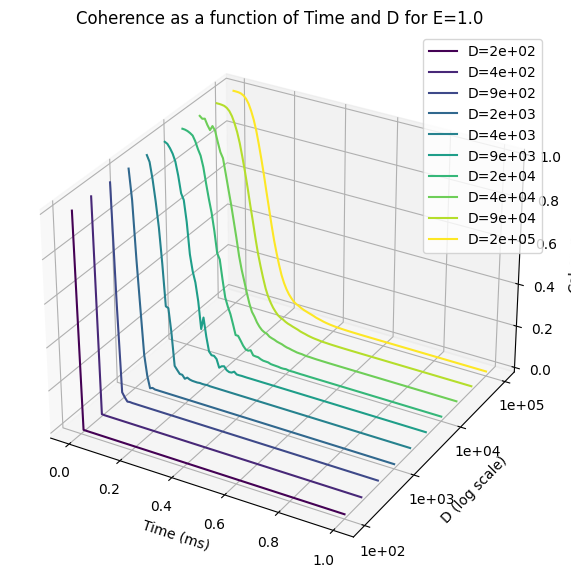

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


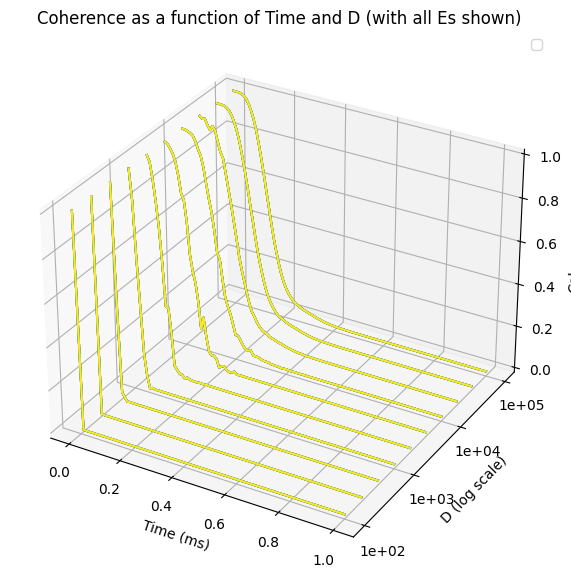

In [89]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




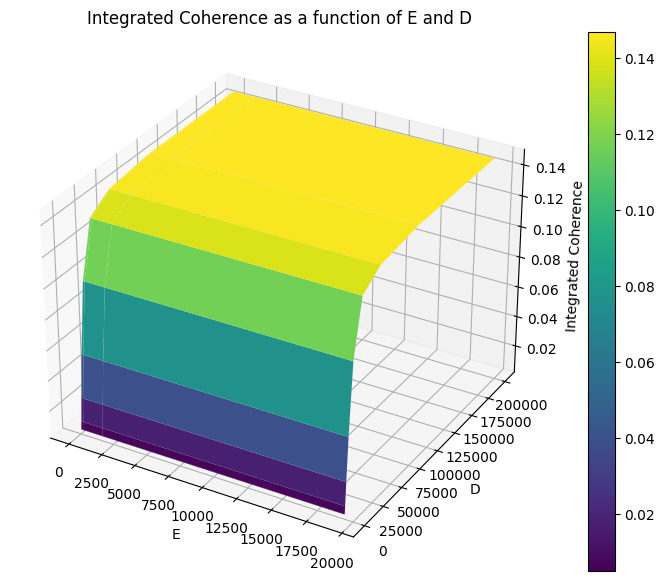

In [90]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Calculate integrated coherence for each E, D pair
Z = np.array([[integrate(time_space, coherence_dict[(d, e)]) for e in unique_E_values] for d in unique_D_values])

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(E, D, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('Integrated Coherence')
ax.set_title('Integrated Coherence as a function of E and D')

plt.show()
